In [2]:
import sys
import os
import importlib

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import files
importlib.reload(files)

import utils
importlib.reload(utils)

from files import *
from utils import *  

In [3]:
"""
Fusion des DataFrames de Text,tint ,wind , solar, ground pour la zone climatique : Toulouse
"""
Text_combined_tou = pd.concat(
    [Text_agen,
     Text_albi,
     Text_auch,
     Text_toulouse],
    axis=0).reset_index(drop=True)

Wind_combined_tou=pd.concat(
    [wind_agen,
    wind_albi,
    wind_auch,
    wind_toulouse],
    axis=0).reset_index(drop=True)

Solar_combined_tou=pd.concat(
    [solar_agen,
     solar_albi,
     solar_auch,
     solar_toulouse],
    axis=0).reset_index(drop=True)

Ground_combined_tou=pd.concat(
    [ground_agen,
     ground_albi,
     ground_auch,
     ground_toulouse],
    axis=0).reset_index(drop=True)

Solar_combined_zur=pd.concat(
    [solar_Birmensdorf,
     solar_Taenikon,
     solar_Zurich_fluntern,
     solar_Zurich_kloten],
    axis=0).reset_index(drop=True)

Tint_combined_tou = pd.concat(
    [Tint_agen,
     Tint_albi,
     Tint_auch,
     Tint_toulouse],
    axis=0).reset_index(drop=True)



In [4]:
model ={ 
    "Logistic Regression": LogisticRegression(
        random_state=42,
        max_iter=1000
    )   
}


In [5]:
# Prédiction des clusters de consommation en fonction  de Text avec   LogisticRegression

def prediction(X_train, X_test, y_train, y_test, models):
    results = []
    preds_dfs = {}

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        execution_time = time.time() - start_time

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            "model": name,
            "accuracy": accuracy,
            "f1_score": f1,
            "execution_time (s)": execution_time
        })

        # DataFrame prédictions + vérité terrain
        preds_df = pd.DataFrame({          
            "y_pred": y_pred
        }).reset_index(drop=True)
        preds_dfs[name] = preds_df

        print(f"{name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Time: {execution_time:.2f}s")

    results_df = pd.DataFrame(results)
    return results_df, preds_dfs

In [6]:
Text_conso_heat_tou

NameError: name 'Text_conso_heat_tou' is not defined

In [7]:
Text_conso_heat_tou=Text_combined_tou.copy()
Text_conso_heat_tou = Text_conso_heat_tou.reset_index()
Text_conso_heat_tou['heat_on'] = conso_tou['heat_on']
Text_conso_heat_tou['clusters'] = conso_tou['clusters']
conso_tou.columns = list(range(24,24+conso_tou.shape[1]))

Text_conso_heat_tou = pd.concat([Text_conso_heat_tou, conso_tou.iloc[:, :-2]], axis=1)
Text_conso_heat_tou.columns = Text_conso_heat_tou.columns.astype(str)


Text_conso_heat_tou_down=downsample_majority_class(
    Text_conso_heat_tou,
    'heat_on'
)


In [8]:

cols_to_drop = ["clusters", "index"] + list(Text_conso_heat_tou_down.columns[-24:])
X = Text_conso_heat_tou_down.drop(columns=cols_to_drop)
y = Text_conso_heat_tou_down["clusters"]

X_train,X_test,y_train,y_test=train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

results_split,df_resultat = prediction(
    X_train,
    X_test,
    y_train,
    y_test,
    model
)



Logistic Regression - Accuracy: 0.8275, F1-score: 0.8257, Time: 0.60s


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


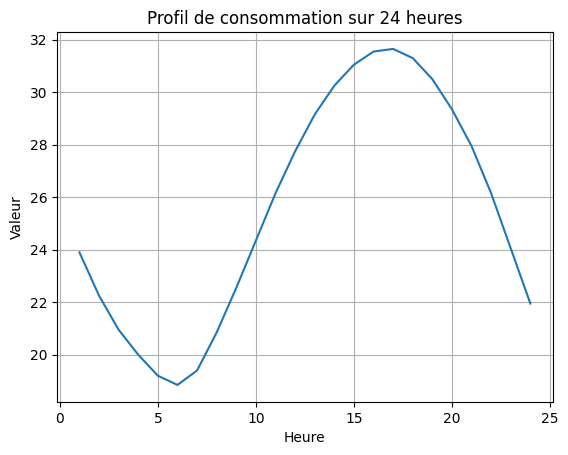

In [22]:
import matplotlib.pyplot as plt

# Sélection de la première ligne et des 24 premières colonnes
valeurs = Text_conso_heat_tou_down.iloc[0, 1:25]

# Tracé
plt.plot(range(1, 25), valeurs)
plt.xlabel("Heure")
plt.ylabel("Valeur")
plt.title("")
plt.grid(True)
plt.show()


In [9]:
# La dernière colonne du DataFrame équilibré Text_conso_heat_tou_down contient le cluster prédit pour les données de test, 
# et la valeur réelle du cluster pour les données d'entraînement.

df_preds = df_resultat["Logistic Regression"]
test_indices = X_test.index

Text_conso_heat_tou_down["y_pred"] = Text_conso_heat_tou_down["clusters"]
Text_conso_heat_tou_down.loc[test_indices, "y_pred"] = df_preds["y_pred"].values   

In [18]:
# Préparation des données pour un modèle LSTM avec des séquences de 48 vecteurs horaires :
# les 24 premiers vecteurs représentent les valeurs réelles du jour passé,
# et les 24 suivants représentent les valeurs prédites  du jour suivant.
# Chaque vecteur contient 3 valeurs : température, statut (on/off), et cluster.
# La prédiction est réalisée sur le DataFrame des jours équilibrés,
# en utilisant la colonne 1 (ID du jour) pour récupérer le vrai jour passé dans le DataFrame non équilibré,
# et le jour à prédire dans le DataFrame équilibré.



scaler_temp = StandardScaler() 
scaler_cons = StandardScaler()

df = Text_conso_heat_tou.copy()
df_scaled = np.hstack([
    df.iloc[:, 0:1].values,
    scaler_temp.fit_transform(df.iloc[:, 1:25]),   
    df.iloc[:, 25:26].values,   #column heat_on  
    df.iloc[:, 26:27].values,   #column CLUSTER reel
      
])
df_final = pd.DataFrame(df_scaled)
data = df_final.values  


df = Text_conso_heat_tou_down.copy()
df_scaled_equilibre = np.hstack([
    df.iloc[:, 0:1].values,    #id de jour 
    scaler_temp.fit_transform(df.iloc[:, 1:25]),   #Text
    df.iloc[:, 25:26].values,   #column heat_on  
    df.iloc[:, -1:].values,   #column CLUSTER predit 
    scaler_cons.fit_transform(df.iloc[:, -25:-1]) #24 h de conso
])
df_final = pd.DataFrame(df_scaled_equilibre)
data_equilibre = df_final.values  


X, y = [], []
jours = np.unique(data_equilibre[:, 0])
for i in jours:
    features = []
    # on filtre les lignes du jour précédent
    jour_passe_lignes = data[data[:, 0] == i-1] 
    if len(jour_passe_lignes) == 0:
        continue  # pas de jour précédent → on saute

    jour_passe = jour_passe_lignes[0] #  on accède à la première ligne
    for j in range(1,25):
        featurespasse = np.array([
            jour_passe[j],      # température horaire
           jour_passe[25],     # heat_on
           jour_passe[26],     # CLUSTER reel 
        ])
        features.append(featurespasse)
        
    jour_predit = data_equilibre[data_equilibre[:, 0] == i][0]
    for j in range(1,25):
        featurespresent = np.array([
                jour_predit[j],      # température horaire
                jour_predit[25],     # heat_on
                jour_predit[26],     # CLUSTER predit
        ])
        features.append(featurespresent)

    features = np.array(features)
    X.append(features)   
    y.append(jour_predit[-24:])


X = np.array(X)
y = np.array(y)

X_train,X_test,y_train,y_test=train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.9187 - mae: 0.7080 - mse: 0.9187 - val_loss: 0.6616 - val_mae: 0.5210 - val_mse: 0.6616
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5424 - mae: 0.4659 - mse: 0.5424 - val_loss: 0.4522 - val_mae: 0.4185 - val_mse: 0.4522
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4005 - mae: 0.3952 - mse: 0.4005 - val_loss: 0.3493 - val_mae: 0.3724 - val_mse: 0.3493
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2996 - mae: 0.3502 - mse: 0.2996 - val_loss: 0.2865 - val_mae: 0.3452 - val_mse: 0.2865
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2584 - mae: 0.3361 - mse: 0.2584 - val_loss: 0.2825 - val_mae: 0.3429 - val_mse: 0.2825
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2703 - mae: 0.3379 - mse: 0.2703 - val_loss: 0.2780 - val_mae: 0.3391 - val_mse: 0.2780
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2389 - mae: 0.3200 - mse: 0.2389 - val

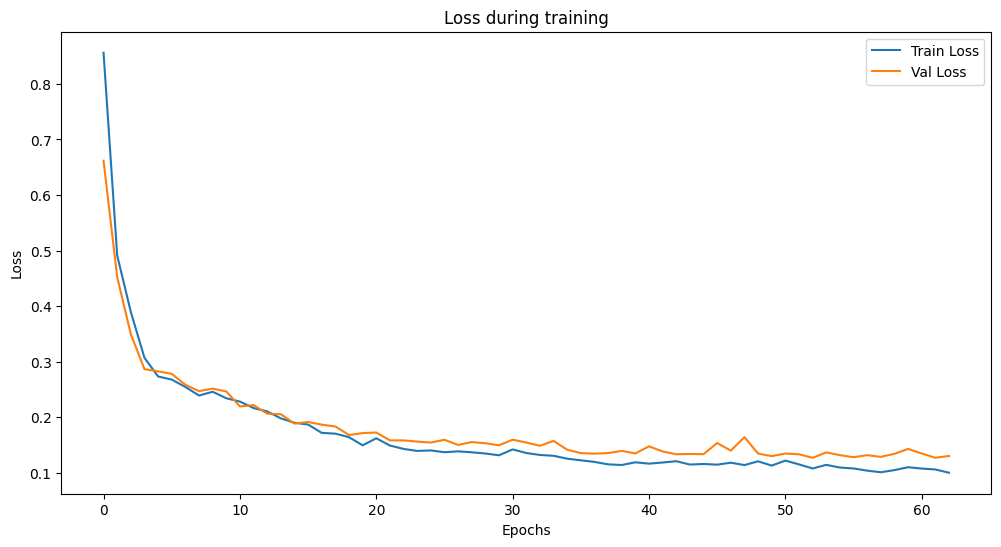

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1346 - mae: 0.2142 - mse: 0.1346
Validation Loss : 0.12679120898246765
Validation MAE: 0.2078692466020584
Validation MSE: 0.12679120898246765
Validation RMSE: 0.35607753226294364
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
Test MAE: 111.96980446084967
Test MSE: 58402.95061245803
Test RMSE: 241.66702425539575
Test R²: 0.8884251363101955
Test CVRMSE: 0.7372227830793411


In [19]:
model = Sequential()
model.add(LSTM(68, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(24, activation='linear'))

history, loss, mae, mse, rmse, mae_test, mse_test, rmse_test, r2, cvrmse, predictions = train_and_evaluate(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    scaler_temp,
    scaler_cons
)


In [28]:
# Préparation des données pour un modèle LSTM avec des séquences de 48 vecteurs horaires :
# les 24 premiers vecteurs représentent les valeurs réelles du jour passé,
# et les 24 suivants représentent les valeurs prédites  du jour suivant.
# Chaque vecteur contient 3 valeurs : température, statut (on/off), et 1 heure de  profil de conso parmi les 24 .
# pour le jour a predit les valuer de conso dans le vecteur egal =0

Text_conso_24_heat_tou=Text_conso_heat_tou.copy()
Text_conso_24_heat_tou['heat_on'] = Text_conso_heat_tou['heat_on']
Text_conso_24_heat_tou['clusters'] = Text_conso_heat_tou['clusters']
Text_conso_24_heat_tou = pd.concat([Text_conso_24_heat_tou, conso_tou.iloc[:, :-2]], axis=1)

Text_conso_24_heat_tou = Text_conso_24_heat_tou.reset_index()
Text_conso_24_heat_tou.columns = Text_conso_24_heat_tou.columns.astype(str)



df = Text_conso_24_heat_tou.copy()
scaler_temp = StandardScaler() 
scaler_cons = StandardScaler()

df_scaled = np.hstack([
    scaler_temp.fit_transform(df.iloc[:, 1:25]),   
    df.iloc[:, 25:26].values,   #column heat_on  
    df.iloc[:, 26:27].values,   #column CLUSTER reel
    scaler_cons.fit_transform(df.iloc[:, -24:])  
])

df_final = pd.DataFrame(df_scaled)
data = df_final.values  


X, y = [], []

jours = np.unique(data_equilibre[:, 0])

for i in range(1, len(data)):
    features = []
    for j in range(24):
        featurespasse = np.array([
            data[i-1, j],      # température horaire
            data[i-1, 24],     # heat_on
            data[i-1, j+26],     # consommation à l'heure précédente (si tu veux inclure)
        ])
        features.append(featurespasse)
    for j in range(24):
        featurespresent = np.array([
                data[i, j],      # température horaire
                data[i, 24],     # heat_on
                0,     # consommation à l'heure précédente (si tu veux inclure)
        ])
        features.append(featurespresent)

    features = np.array(features)
    X.append(features)     
    y.append(data[i, 26:])  # consommation cible

X = np.array(X)
y = np.array(y)

X_train=X[:int((X.shape[0]*8)/10),:]
X_test=X[int((X.shape[0]*8)/10):,:]
y_train=y[:int((y.shape[0]*8)/10),:]
y_test=y[int((y.shape[0]*8)/10):,:]



Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.1269 - mae: 0.7858 - mse: 1.1269 - val_loss: 0.6456 - val_mae: 0.5356 - val_mse: 0.6456
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5803 - mae: 0.5075 - mse: 0.5803 - val_loss: 0.4737 - val_mae: 0.4285 - val_mse: 0.4737
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5476 - mae: 0.4772 - mse: 0.5476 - val_loss: 0.4046 - val_mae: 0.4014 - val_mse: 0.4046
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4236 - mae: 0.4261 - mse: 0.4236 - val_loss: 0.3397 - val_mae: 0.3243 - val_mse: 0.3397
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3652 - mae: 0.3890 - mse: 0.3652 - val_loss: 0.3259 - val_mae: 0.3139 - val_mse: 0.3259
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3571 - mae: 0.3731 - mse: 0.3571 - val_loss: 0.3170 - val_mae: 0.3089 - val_mse: 0.3170
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3859 - mae: 0.3912 - mse: 0.3859 - val_loss: 0.264

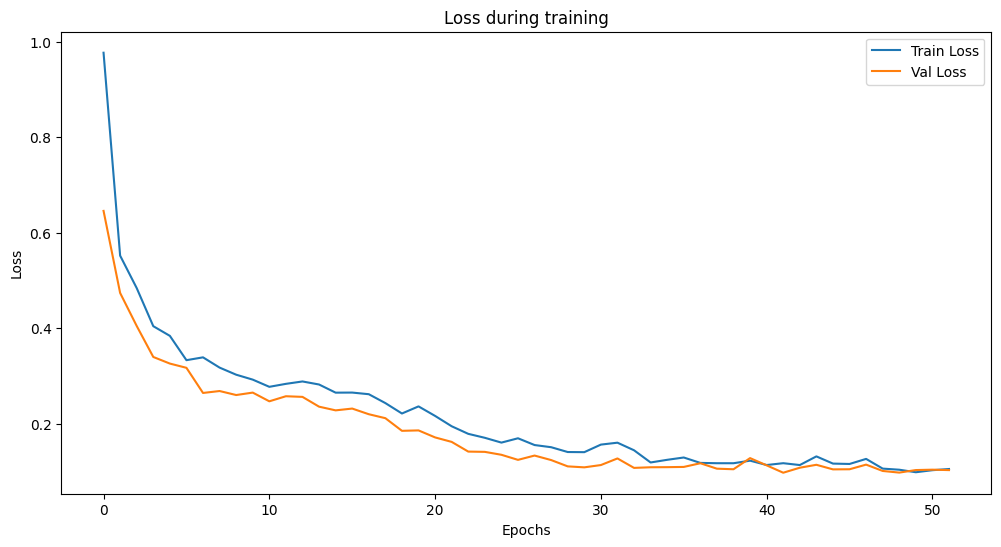

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0996 - mae: 0.1846 - mse: 0.0996
Validation Loss : 0.09727193415164948
Validation MAE: 0.1818423867225647
Validation MSE: 0.09727193415164948
Validation RMSE: 0.31188448847554034
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
Test MAE: 112.35123780247204
Test MSE: 44408.18509503268
Test RMSE: 210.7324965330043
Test R²: 0.9090738365006154
Test CVRMSE: 0.8127534264053222


In [27]:
model = Sequential()
model.add(LSTM(68, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(24, activation='linear'))

history, loss, mae, mse, rmse, mae_test, mse_test, rmse_test, r2, cvrmse, predictions = train_and_evaluate(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    scaler_temp,
    scaler_cons
)
